# Simmulations
## OOP Approach

In [20]:
import sys
sys.path.append("..")

import os
import glob
import numpy as np

%load_ext autoreload
%autoreload 2

from sicm import io
from sicm.models.comsol import ComsolModel
from sicm.plots import plots
from sicm.experiments.scan import Scan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
datadir = "S:\\UsersData\\Martin\\projects\\thermometry\\comsol\\results\\temp"
exp_name = "accum_ecJ3D" + ".txt"
cm = ComsolModel(datadir, exp_name)

In [22]:
datadir = "S:\\UsersData\\Martin\\2019\\05_May\\15\\approach4"
exp_name = "approach4"
cm.add_approach(datadir, exp_name)

Avaliable data:
dict_keys(['Current1(A)', 'dt(s)', 'LineNumber', 'V1(V)', 'Z(um)'])
Number of datapoints = (16063,)


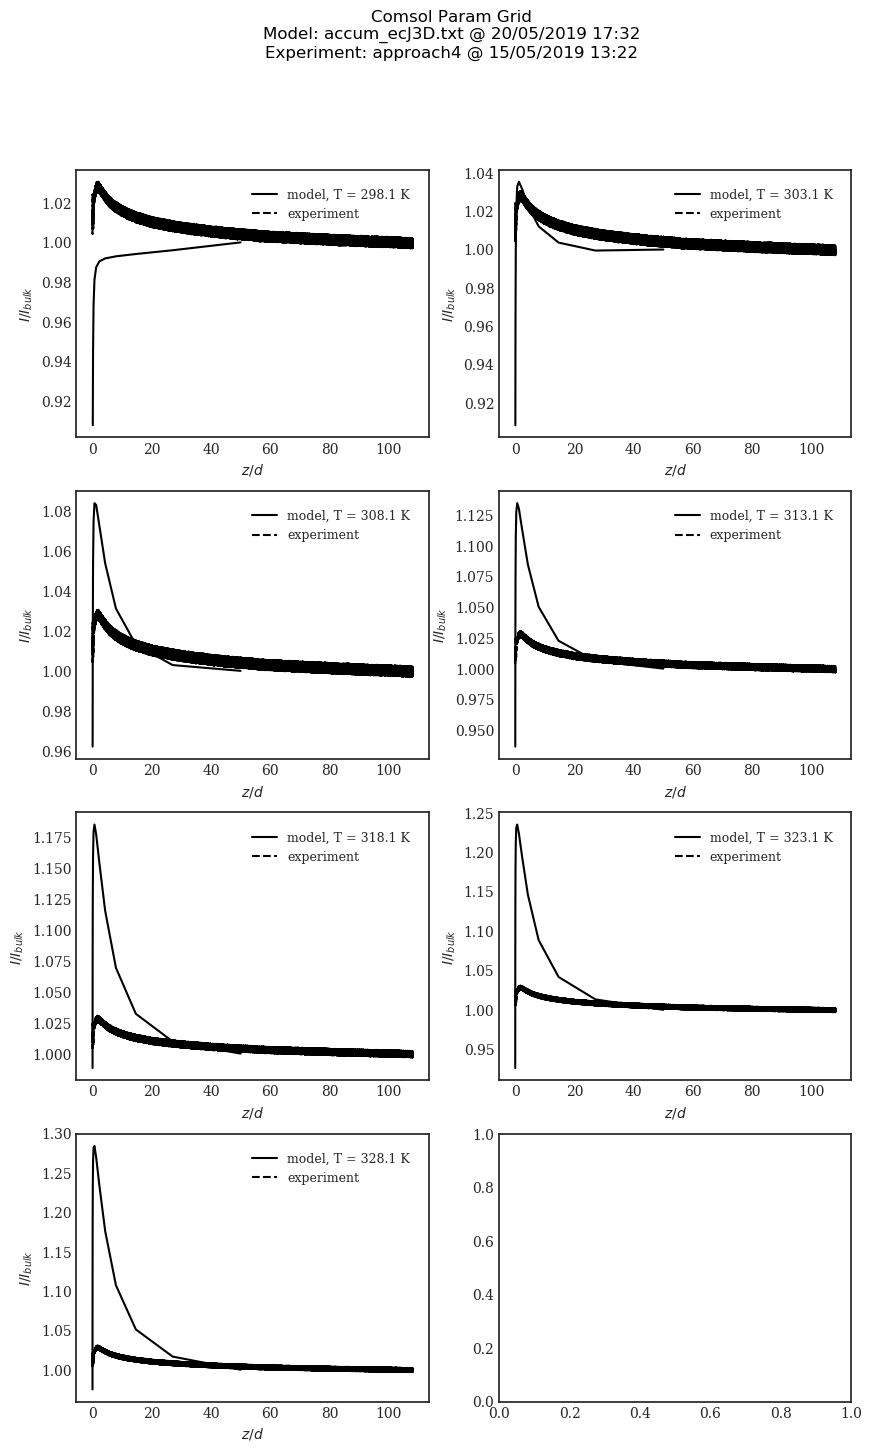

In [25]:
cm.plot_grid()

In [5]:
cm.data["Tsub (K)"].unique()

array([298.1499939 , 309.2611084 , 320.3722229 , 331.4833374 ,
       342.5944519 , 353.70556641, 364.81668091, 375.92776489,
       387.03887939, 398.1499939 ])

# Simulations
## Current-distance characterstic

In [2]:
import sys
sys.path.append("..")

import os
import glob
import numpy as np

%load_ext autoreload
%autoreload 2

from sicm import io
from sicm.models import model
from sicm.plots import plots
from sicm.experiments.scan import Scan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3/"
files = glob.glob(parent + "*.txt")
print(files)

['S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3\\ecJ3D.txt']


Saved figure to I_vs_d_curve.pdf.


C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


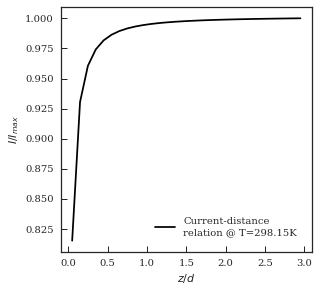

In [14]:
# Current-distance simulation
data = io.load_comsol(files[0])
r_i = 15e-9
x = data.iloc[:, 0] / (r_i*2) # scale by diameter
y = np.asarray(data.iloc[:, 1]) # convert to nanoAmps
y_max = np.max(y) if y[-1] > 0 else np.min(y)
y = y/y_max
leg = "Current-distance relation @ T=298.15K"
plots.plot_generic([x], [y], [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve")

## Current-temperature characteristic

Using $d_{bulk} = 30\cdot r_i$ will have bulk temperature influenced by the $T_{sub}$ value. Numerically this is solved simply by using more proximal set point (and/or more proximal bulk-reference point). Experimentally, this hints on possible issue with the self-referencing. Other explanation would be inability of COMSOL to accurately model heat dissipation in liquid on microscale.

In [130]:
# Current-Tsub simulation
parent = "S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_Tsub/4/"
files = glob.glob(parent + "*.txt")
print(files)
data = io.load_comsol(files[0])
data["d (m)"].unique()

['S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_Tsub/4\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_Tsub/4\\ecJ3D.txt']


array([3.00000003e-09, 1.50000005e-07])

In [131]:
d_sub = data["d (m)"].unique()[0]
d_bulk = data["d (m)"].unique()[-1]
y_sub = data[data["d (m)"] == d_sub].iloc[:, 2].values
y_bulk = data[data["d (m)"] == d_bulk].iloc[:, 2].values
y = y_sub / y_bulk
x = data[data["d (m)"] == d_bulk]["Tsub (K)"].values

Saved figure to inverted_I_vs_Tsub_curve_0100.pdf.


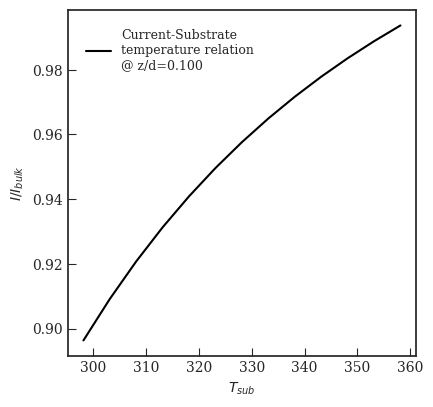

In [132]:
tm = model.TemperatureModel(y, x)
tm.plot(d_sub, r_i, True)

Fitting TemperatureModel._fit_wrapper.<locals>._exponential_fit to 13 datapoints ...
Found parameters: [ 1.18915192e-09 -3.63923898e+02  1.47682791e+01].
Finished in 0.008 s
error on fit: 4.950455623E-04


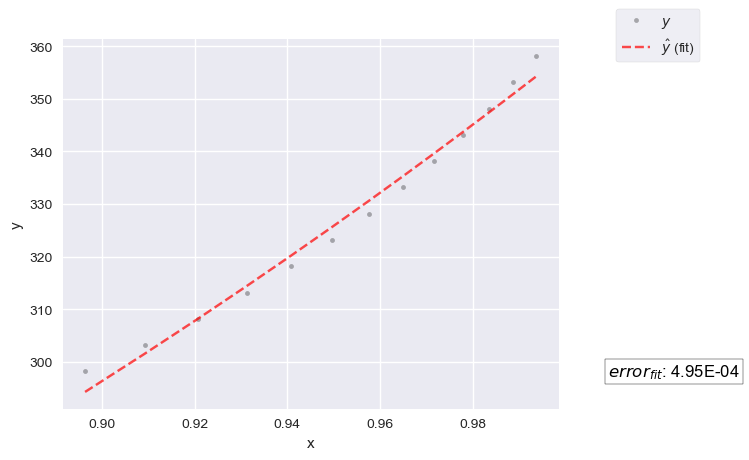

In [133]:
tm.fit(guess = [2.4, -350, 1.8e1], double_ax=False)

Values in `i_exp` are can be sensitive to the choice of baseline. To rule out this is an issue, do sensitivitiy analysis for window_size parameter. I briefly checked two values and `i_exp` was unaffected.

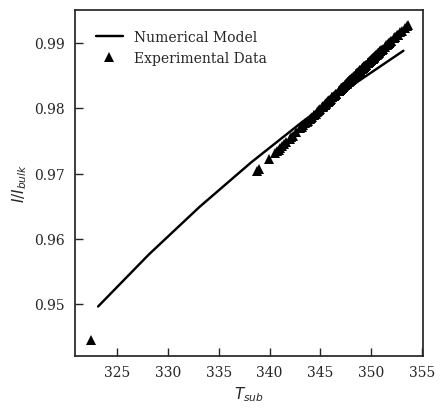

In [134]:
legs = ["Numerical Model", "Experimental Data"]
x_m = tm.predict(i_exp)
idx = np.nonzero(np.logical_and(x>=np.min(x_m), x<=np.max(x_m)))
plots.plot_generic([x[idx], x_m], [y[idx], i_exp], [r"$T_{sub}$"], 
                   [r"$I/I_{bulk}$"], legs, fmts = ["k-", "k^"])

What I have achieved today:
    - T = f(I/I_bulk) @ representative distance
    - discovered issue with self-referencing
    - discovered that we are much further away from surface than with QTF.
    
Ideas for what to do next:
    - check sensitivity to window_size
    - extend domain of i_exp to regions where no particles present
    - write it down on paper for single approach-curve
    - use Analytical model to obtain distance from surface (should not differ too much from the numerical one)

# Analytical model

Saved figure to I_vs_z_curve.pdf.


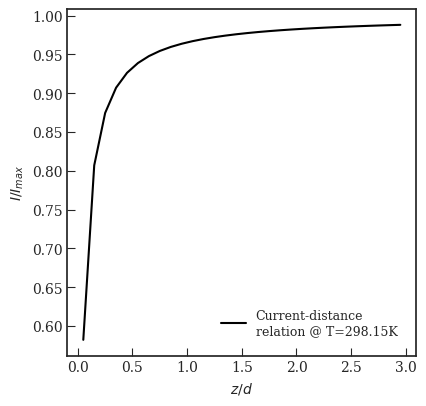

In [16]:
# Analytical Model
r_i = 15e-9
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6
r_p = 2e-6
r_o = 26e-9
z = np.arange(r_i/10, 6*r_i, r_i/5)

sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)
sicm_model.plot(do_invert = False)

# Plot Analytical and Numerical Model Together

In [17]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_d/5/"
files = glob.glob(parent + "*.txt")
print(files)

['S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_d/5\\ecJz.txt', 'S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_d/5\\ecJ3D.txt']


In [18]:
# Current-distance simulation
data = io.load_comsol(files[0])
r_i = 15e-9
x = data.iloc[:, 0] / (r_i*2) # scale by diameter
y = np.asarray(data.iloc[:, 1]) # convert to nanoAmps
y_max = np.max(y) if y[-1] > 0 else np.min(y)
y = y/y_max

In [19]:
# Analytical Model
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6 # some arbitrary value
r_p = h * np.tan(4.78 * np.pi/180)  # we know the angle
r_o = 26e-9

z = x * (2*r_i) # convert to nanometers

sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)

#### Additional explanation
For `r_o`, `18e-9` will give almost perfect fit whereas `26e-9` is according parameters in COMSOL. This discrepancy is not unexpected, because in COMSOL the pipette has "barrel" at its opening, which is not considered in the analytical model.

Similar effect could be achieved by reducing the angle $\alpha$ (to about 2.5).

In [20]:
thresh = 1.0
# Simulation
xx = x[x<=thresh]
yy = y[x<=thresh]
# Model
xx_m = x[x<=thresh]
y_m = sicm_model.I / (sicm_model.U/sicm_model.R_p)
yy_m = y_m[x<=thresh]

Saved figure to I_vs_d_curve_both.pdf.


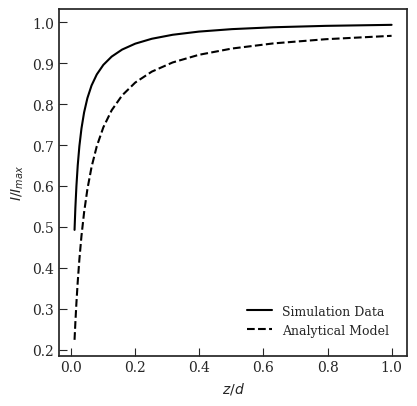

In [21]:
leg = ["Simulation Data", "Analytical Model"]
plots.plot_generic([xx, xx_m], [yy, yy_m], 
                   [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve_both")

# Fit functional relationship to data

Fit function of the form of an analytical model to the simulations data. Use inverted relationship $d = f(I)$ and prefer to work with scaled values $\frac{d}{2r_i} = f(\frac{I}{I_{max}})$.

Physical interperatation of parameters is possible. $\alpha$ is the inner opening angle of the pipette and $r_o$ is the outter diameter at the tip opening.

Quality of the fit decreases with wider range $z/d$. Good balance spans relevant distances while still giving good fit.

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 18 datapoints ...
Found parameters: [3.57732100e+00 1.83566047e-08].
Finished in 0.006 s
error on fit: 2.401766554E-02


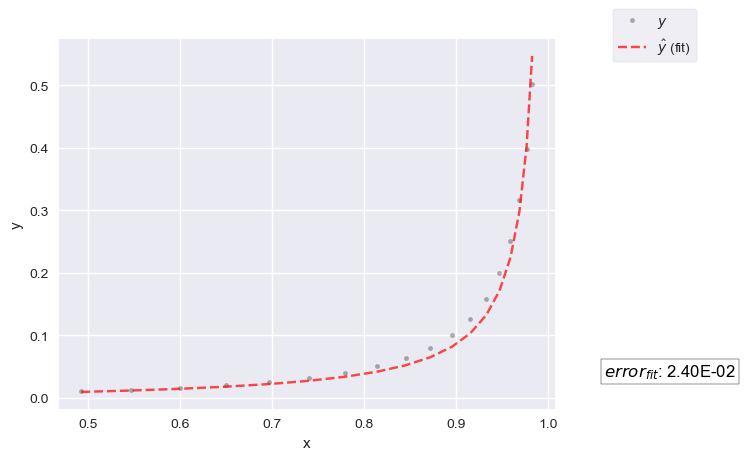

In [22]:
guess = [4.78, 18e-9]
sicm_model.fit(x[:-13], y[:-13], guess, False)

Saved figure to I_vs_d_curve_fit.pdf.


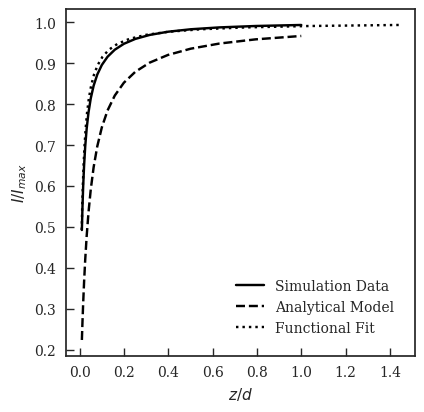

In [23]:
leg = ["Simulation Data", "Analytical Model", "Functional Fit"]
plots.plot_generic([xx, xx_m, sicm_model.predict(yy, sicm_model.popt)], [yy, yy_m, yy], 
                   [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve fit")

## Get distance from experimental data

### Batch from QTF + SICM data

In [65]:
data_dirs = ["S:/UsersData/Martin/2018/12_Dec/12/sicm/exp3",
            "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp1",
            "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp2",
            "S:/UsersData/Martin/2018/12_Dec/21",
            "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp4"]
exp_names = ["scan_hopping_qtf_current_fast",
            "scan_hopping_qtf_current",
            "scan_hopping_qtf_current_slow",
            "scan1",
            "scan_hopping_qtf_current_veryfast"]
i_exps = []
for dd, en in zip(data_dirs, exp_names):
    try:
        df = io.load_dataframe([dd, en + "_annot.pkl"])
    except FileNotFoundError as e:
        from sicm.experiments.scan import Scan
        scan = Scan(dd, en)
        scan.annotate_peaks()
        df = io.load_dataframe([dd, en + "_annot.pkl"])
    i_exp = df["Current1(A)"]["peaks_val"]/df["Current1(A)"]["baseline"]
    i_exps.append(i_exp)
i_exp = np.hstack(i_exps)

### Do it for SICM-only data

Distribution is relatively tight so you may get away with using single of distance from surface. I would be happier if I had function $T = f(z/d, I_{sub}/I_{bulk})$ though, because currently I have $T = f(I_{sub}/I_{bulk})$ which may be innacurate for approahc that hit the threhsold ealier or later.

In this particlar example, I look only on approaches right above the heated-up particles (I selected x,y range to correspond).

In [126]:
data_dir = "S:/UsersData/Martin/2019/03_Mar/15/sicm/scan6"
exp_name = "scan6"
fpath = os.path.join(data_dir, exp_name)
df = io.load_dataframe([data_dir, exp_name + "_annot.pkl"])
i_exp = df["Current1(A)"]["peaks_val"]/df["Current1(A)"]["baseline"]

Saved figure to S:/UsersData/Martin/2019/03_Mar/15/sicm/scan6\scan6_feedback_distance.pdf.


C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
C:\Users\mholub\AppData\Local\Continuum\miniconda3\envs\sicm\lib\site-packages\matplotlib\__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


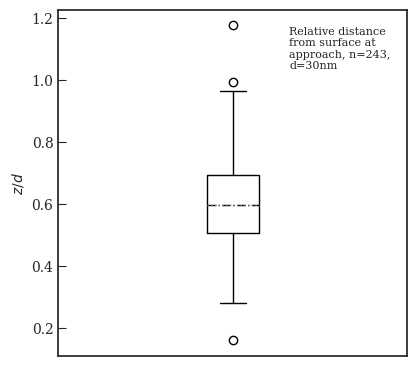

In [71]:
z_rel = sicm_model.predict(i_exp)
legend = "Relative distance from surface at approach," + \
        " n={}, d={:.0f}nm".format(len(z_rel), np.round(2*r_i*1e9))
plots.boxplot_generic(z_rel, "", r"$z/d$", legend = legend,
                     fname = fpath + "_feedback_distance")
# dash-dot is median, dotted is mean

In [ ]:
import sys
sys.path.append("..")

import os
import glob
import numpy as np

%load_ext autoreload
%autoreload 2

from sicm import io, model
from sicm.plots import plots
from sicm.experiments.scan import Scan

# Simulations
## Current-distance characterstic

parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/3/"
files = glob.glob(parent + "*.txt")
print(files)

# Current-distance simulation
data = io.load_comsol(files[0])
r_i = 15e-9
x = data.iloc[:, 0] / (r_i*2) # scale by diameter
y = np.asarray(data.iloc[:, 1]) # convert to nanoAmps
y_max = np.max(y) if y[-1] > 0 else np.min(y)
y = y/y_max
leg = "Current-distance relation @ T=298.15K"
plots.plot_generic([x], [y], [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve")

## Current-temperature characteristic

Using $d_{bulk} = 30\cdot r_i$ will have bulk temperature influenced by the $T_{sub}$ value. Numerically this is solved simply by using more proximal set point (and/or more proximal bulk-reference point). Experimentally, this hints on possible issue with the self-referencing. Other explanation would be inability of COMSOL to accurately model heat dissipation in liquid on microscale.

# Current-Tsub simulation
parent = "S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_Tsub/4/"
files = glob.glob(parent + "*.txt")
print(files)
data = io.load_comsol(files[0])
data["d (m)"].unique()

d_sub = data["d (m)"].unique()[0]
d_bulk = data["d (m)"].unique()[-1]
y_sub = data[data["d (m)"] == d_sub].iloc[:, 2].values
y_bulk = data[data["d (m)"] == d_bulk].iloc[:, 2].values
y = y_sub / y_bulk
x = data[data["d (m)"] == d_bulk]["Tsub (K)"].values

tm = model.TemperatureModel(y, x)
tm.plot(d_sub, r_i, True)

tm.fit(guess = [2.4, -350, 1.8e1], double_ax=False)

Values in `i_exp` are can be sensitive to the choice of baseline. To rule out this is an issue, do sensitivitiy analysis for window_size parameter. I briefly checked two values and `i_exp` was unaffected.

legs = ["Numerical Model", "Experimental Data"]
x_m = tm.predict(i_exp)
idx = np.nonzero(np.logical_and(x>=np.min(x_m), x<=np.max(x_m)))
plots.plot_generic([x[idx], x_m], [y[idx], i_exp], [r"$T_{sub}$"], 
                   [r"$I/I_{bulk}$"], legs, fmts = ["k-", "k^"])

What I have achieved today:
    - T = f(I/I_bulk) @ representative distance
    - discovered issue with self-referencing
    - discovered that we are much further away from surface than with QTF.
    
Ideas for what to do next:
    - check sensitivity to window_size
    - extend domain of i_exp to regions where no particles present
    - write it down on paper for single approach-curve
    - use Analytical model to obtain distance from surface (should not differ too much from the numerical one)

# Analytical model

# Analytical Model
r_i = 15e-9
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6
r_p = 2e-6
r_o = 26e-9
z = np.arange(r_i/10, 6*r_i, r_i/5)

sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)
sicm_model.plot(do_invert = False)

# Plot Analytical and Numerical Model Together

parent = "S:/UsersData/Martin/projects/thermometry/comsol/recovered/I_vs_d/5/"
files = glob.glob(parent + "*.txt")
print(files)

# Current-distance simulation
data = io.load_comsol(files[0])
r_i = 15e-9
x = data.iloc[:, 0] / (r_i*2) # scale by diameter
y = np.asarray(data.iloc[:, 1]) # convert to nanoAmps
y_max = np.max(y) if y[-1] > 0 else np.min(y)
y = y/y_max

# Analytical Model
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6 # some arbitrary value
r_p = h * np.tan(4.78 * np.pi/180)  # we know the angle
r_o = 26e-9

z = x * (2*r_i) # convert to nanometers

sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)

#### Additional explanation
For `r_o`, `18e-9` will give almost perfect fit whereas `26e-9` is according parameters in COMSOL. This discrepancy is not unexpected, because in COMSOL the pipette has "barrel" at its opening, which is not considered in the analytical model.

Similar effect could be achieved by reducing the angle $\alpha$ (to about 2.5).

thresh = 1.0
# Simulation
xx = x[x<=thresh]
yy = y[x<=thresh]
# Model
xx_m = x[x<=thresh]
y_m = sicm_model.I / (sicm_model.U/sicm_model.R_p)
yy_m = y_m[x<=thresh]

leg = ["Simulation Data", "Analytical Model"]
plots.plot_generic([xx, xx_m], [yy, yy_m], 
                   [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve_both")

# Fit functional relationship to data

Fit function of the form of an analytical model to the simulations data. Use inverted relationship $d = f(I)$ and prefer to work with scaled values $\frac{d}{2r_i} = f(\frac{I}{I_{max}})$.

Physical interperatation of parameters is possible. $\alpha$ is the inner opening angle of the pipette and $r_o$ is the outter diameter at the tip opening.

Quality of the fit decreases with wider range $z/d$. Good balance spans relevant distances while still giving good fit.

guess = [4.78, 18e-9]
sicm_model.fit(x[:-13], y[:-13], guess, False)

leg = ["Simulation Data", "Analytical Model", "Functional Fit"]
plots.plot_generic([xx, xx_m, sicm_model.predict(yy, sicm_model.popt)], [yy, yy_m, yy], 
                   [r"$z/d$"], [r"$I/I_{max}$"], leg, "I vs. d curve fit")

## Get distance from experimental data

### Batch from QTF + SICM data

data_dirs = ["S:/UsersData/Martin/2018/12_Dec/12/sicm/exp3",
            "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp1",
            "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp2",
            "S:/UsersData/Martin/2018/12_Dec/21",
            "S:/UsersData/Martin/2018/12_Dec/12/sicm/exp4"]
exp_names = ["scan_hopping_qtf_current_fast",
            "scan_hopping_qtf_current",
            "scan_hopping_qtf_current_slow",
            "scan1",
            "scan_hopping_qtf_current_veryfast"]
i_exps = []
for dd, en in zip(data_dirs, exp_names):
    try:
        df = io.load_dataframe([dd, en + "_annot.pkl"])
    except FileNotFoundError as e:
        from sicm.experiments.scan import Scan
        scan = Scan(dd, en)
        scan.annotate_peaks()
        df = io.load_dataframe([dd, en + "_annot.pkl"])
    i_exp = df["Current1(A)"]["peaks_val"]/df["Current1(A)"]["baseline"]
    i_exps.append(i_exp)
i_exp = np.hstack(i_exps)

### Do it for SICM-only data

Distribution is relatively tight so you may get away with using single of distance from surface. I would be happier if I had function $T = f(z/d, I_{sub}/I_{bulk})$ though, because currently I have $T = f(I_{sub}/I_{bulk})$ which may be innacurate for approahc that hit the threhsold ealier or later.

In this particlar example, I look only on approaches right above the heated-up particles (I selected x,y range to correspond).

data_dir = "S:/UsersData/Martin/2019/03_Mar/15/sicm/scan6"
exp_name = "scan6"
fpath = os.path.join(data_dir, exp_name)
df = io.load_dataframe([data_dir, exp_name + "_annot.pkl"])
i_exp = df["Current1(A)"]["peaks_val"]/df["Current1(A)"]["baseline"]

z_rel = sicm_model.predict(i_exp)
legend = "Relative distance from surface at approach," + \
        " n={}, d={:.0f}nm".format(len(z_rel), np.round(2*r_i*1e9))
plots.boxplot_generic(z_rel, "", r"$z/d$", legend = legend,
                     fname = fpath + "_feedback_distance")
# dash-dot is median, dotted is mean

-------------
# Code Graveyard

## Fit functional relationship to data (Old Version)

In [4]:
# obtain a model that yields distance for some measured current
r_i = 15e-9
U = 0.1
kappa = 3.7 # 1/(Ohm*m), read from plot for T = 298.15K, can calculate later
h = 23e-6
r_p = 2e-6
r_o = 26e-9
z = np.arange(r_i/10, 6*r_i, r_i/5)

# continue here by fitting inverse relationship
sicm_model = model.SICMModel(z, U, h, kappa, r_p, r_i, r_o)

In [5]:
parent = "S:/UsersData/Martin/projects/thermometry/comsol/I_vs_d/4/"
files = glob.glob(parent + "*.txt")
data = io.load_comsol(files[0])
z = data.iloc[:, 0]
i = np.abs(np.asarray(data.iloc[:, 1]))
i_max = np.max(i)

### Version A 

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 50 datapoints ...
Found parameters: [9.31186278e-07 4.09167025e-05 1.06888822e+01].
Finished in 0.004 s
error on fit: 1.250599772E-01


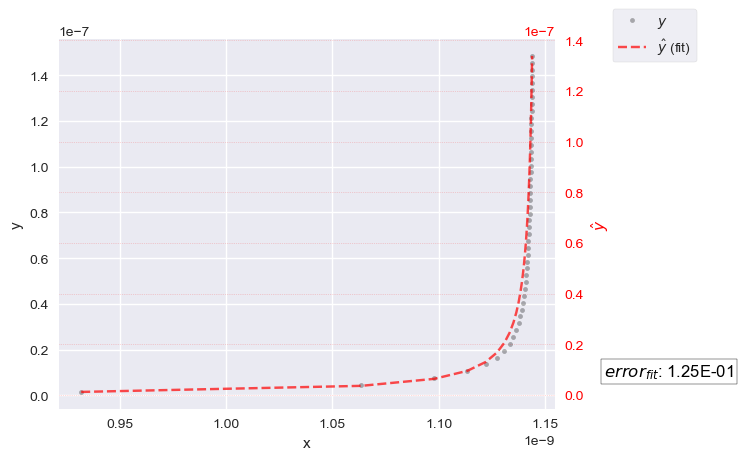

In [6]:
guess = [r_p, h, kappa**2]
sicm_model.fit(z, i, guess)

error on fit: 1.250599772E-01


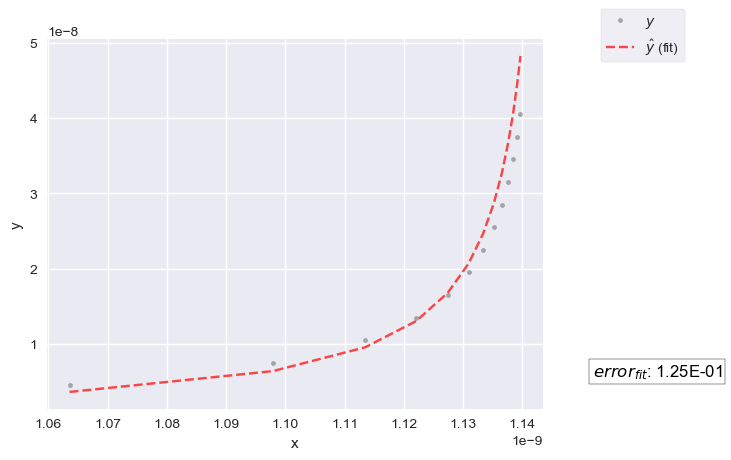

In [7]:
sicm_model.plot_fit(z, i, plot_range = [1.05e-9, 1.14e-9])

### Version B

Fitting SICMModel.fit_wrapper.<locals>._inverse_fit to 50 datapoints ...
Found parameters: [-3.43704563e-07 -5.93633046e-13  3.67068962e+02].
Finished in 0.004 s
error on fit: 2.041555755E-02


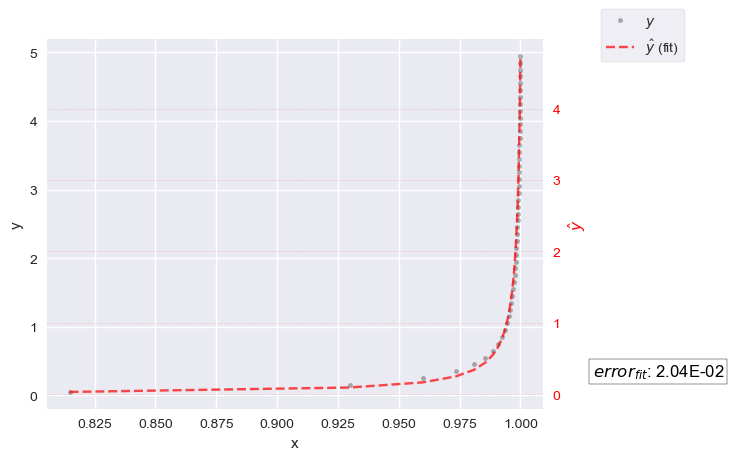

In [36]:
guess = [r_p, h*r_i/4,(kappa)/np.sqrt((i_max/U))]
sicm_model.fit(z/(2*r_i), i/i_max, guess)

error on fit: 2.041555755E-02


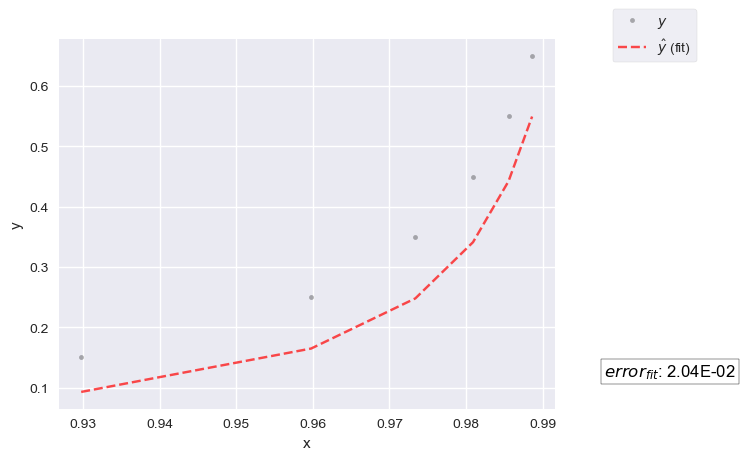

In [37]:
sicm_model.plot_fit(z/(2*r_i), i/i_max, plot_range = [0.925, .99])